# 1. Determining optimal probability cut-off
Predicted probability is a number between **0** and **1**. Traditionally, probability **>= 0.5** is a *cut-off point* used for converting predicted proabability to **1** (*positive*) otherwise **0** (*negative*). This logic works well when your training data set has equal example of positive and negative samples, however this is not the case in real world scenarios.

The solution is to find the optimal *cut-off* point, that is the point where **true positive rate** is high and the **false positive rate** is low. Anything above this threshold can be labeled as **1** else **0**. Let's understand this better with an example.

We'll be using the dataset from the **UCI repository**, dataset *Pima Indian diabetes*: 2 classes, 8 attributes, 768 instances, 500 (65.1%) negative (class1), and 268 (34.9%) positive tests for diabetes (class2). All patients were females at least 21 years old of Pima Indian heritage.

Attributes used:
1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)

## Exercise 1: Read the input data

In [1]:
# Load libraries
import pandas as pd
import pylab as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
# Read the data from the Diabetes.csv file
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Lab09/Diabetes.csv')
print(df.head())
print()

# Target variable % distribution
print (df['class'].value_counts(normalize = True))

X = df.iloc[:, :8]    # Independent variables aaaa
Y = df['class']       # Dependent variable

Mounted at /content/drive
   preg_count  glucose_concentration  blood_pressure  skin_thickness  \
0           6                    148              72              35   
1           1                     85              66              29   
2           8                    183              64               0   
3           1                     89              66              23   
4           0                    137              40              35   

   serum_insulin   bmi  pedigree_function  age  class  
0              0  33.6              0.627   50      1  
1              0  26.6              0.351   31      0  
2              0  23.3              0.672   32      1  
3             94  28.1              0.167   21      0  
4            168  43.1              2.288   33      1  

class
0    0.651042
1    0.348958
Name: proportion, dtype: float64


**Questions:**
1. What do the numbers **0** and **1** in the *class* column mean?
2. In your opinion, is the dataset balanced or not? Why do you think so?

**Answers:**

## Exercise 2: Model building and evaluation

In [3]:
# Evaluate the model by splitting into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

# Instantiate a logistic regression model, and fit
model = LogisticRegression(max_iter=200)
model = model.fit(X_train, Y_train)

# Predict class labels for the train set
# The predict() fuction converts probability values >= 0.5 to 1 else 0
Y_pred = model.predict(X_train)
print('Example results of the predict() function:', Y_pred[0:5])

# Generate class probabilities with the predict_proba() function
# Notice that 2 elements will be returned in probs array,
# 1st element is a probability for negative class,
# 2nd element gives probability for positive class
probs = model.predict_proba(X_train)
Y_pred_prob = probs[:, 1]
print('\nExample results of the predict_proba() function:\n', probs[0:5, :])

# Generate evaluation metrics
print ('\nAccuracy:', metrics.accuracy_score(Y_train, Y_pred))

Example results of the predict() function: [0 0 1 0 1]

Example results of the predict_proba() function:
 [[0.71019603 0.28980397]
 [0.6685187  0.3314813 ]
 [0.05821522 0.94178478]
 [0.63179344 0.36820656]
 [0.20770644 0.79229356]]

Accuracy: 0.7690875232774674


**Questions:**
1. What is a difference between the results returned by the predict() and predict_proba() functions?
2. How would you use these functions when solving a binary classification task?

**Answers:**

## Exercise 3: Building the ROC curve

Area under the ROC curve (AUC): 0.840685598750115


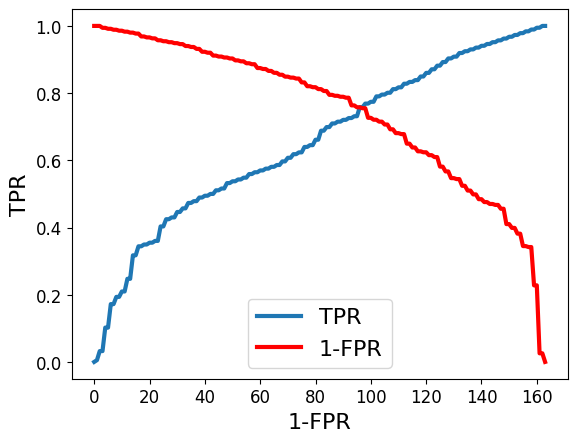

In [4]:
# Extract false positive rate (fpr), true positive rate (tpr) and thresholds
FPR, TPR, thresholds = metrics.roc_curve(Y_train, Y_pred_prob)
ROC_AUC = metrics.auc(FPR, TPR)
print ('Area under the ROC curve (AUC):', ROC_AUC)

i = np.arange(len(TPR))    # Index for df
ROC = pd.DataFrame({'FPR': pd.Series(FPR, index = i),
                    'TPR': pd.Series(TPR, index = i),
                    '1-FPR': pd.Series(1-FPR, index = i),
                    'tf': pd.Series(TPR-(1-FPR), index = i),
                    'thresholds': pd.Series(thresholds, index = i)})
ROC.iloc[(ROC.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(ROC['TPR'], label = 'TPR', lw=3)
plt.plot(ROC['1-FPR'], color = 'red', label = '1-FPR', lw=3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=16)
plt.xlabel('1-FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
#plt.title('Receiver operating characteristic')
plt.show()

**Questions:**
1. What do the FPR and TPR parameters mean?
2. What is the AUC parameter used for?

**Answers:**

1. FPR is false positive rate which shows the proportion of negative samples classified as positive. The lower the better.  TPR is true positive rate (also recall) which shows the proportion of positive samples correctly classified as positive. The higher the better.
2. AUC is area under the ROC curve which measures model's abilitiy to differentiate the classes. AUC value 0.5 represents just random guessing, 1.0 is for perfect classifier and if AUC < 0.5 it means that model is misclassifying.

## Exercise 4: Optimal cut-off
The optimal *cut-off* would be where **TPR** is high and **FPR** is low. In this case, **TPR-(1-FPR)** is **zero** or **near to zero**. To simplify finding **optimal probability threshold** and bring in re-usability, we may use a function to find the optimal probability **cut-off** point. The function used returns a list type with optimal **cut-off** value. The meaning of the parameters is as follows:
- **target** - matrix with dependent or target data, where rows are observations;
- **predicted** - matrix with predicted data, where rows are observations.

In [5]:
def Find_Optimal_Cutoff(target, predicted):
    FPR, TPR, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(TPR))
    ROC = pd.DataFrame({'tf': pd.Series(TPR-(1-FPR), index = i), 'threshold': pd.Series(threshold, index = i)})
    ROC_t = ROC.iloc[(ROC.tf-0).abs().argsort()[:1]]
    return list(ROC_t['threshold'])

In [6]:
# Find optimal probability threshold
# Note: probs[:, 1] will have the probability of being a positive label
threshold = Find_Optimal_Cutoff(Y_train, probs[:, 1])
print ('Optimal probability threshold:', threshold)

# Applying the threshold to the prediction probability
Y_pred_optimal = np.where(Y_pred_prob >= threshold, 1, 0)

# Let's compare the accuracy of traditional/normal approach vs. optimal cut-off
print ('\nAccuracy (normal):', metrics.accuracy_score(Y_train, Y_pred))
print ('Accuracy (optimal cut-off):', metrics.accuracy_score(Y_train, Y_pred_optimal))
print ('\nConfusion matrix (normal):\n', metrics.confusion_matrix(Y_train, Y_pred))
print ('\nConfusion matrix (optimal cut-off): \n', metrics.confusion_matrix(Y_train, Y_pred_optimal))

Optimal probability threshold: [0.3199941443976144]

Accuracy (normal): 0.7690875232774674
Accuracy (optimal cut-off): 0.7579143389199255

Confusion matrix (normal):
 [[307  44]
 [ 80 106]]

Confusion matrix (optimal cut-off): 
 [[266  85]
 [ 45 141]]


**Questions:**
1. How did type I and type II errors change after the application of the optimal cut-off?
2. Do you think this change is medically beneficial for patients? Justify your answer.

**Answers:**

# 2. Rare event or unbalanced data set
Providing equal sample of positive and negative instances to the classification algorithm will result in optimal result. Dataset which are highly skewed towards one or more classes have proven to be a challenge.

Resampling is a common practice of addressing this issue. Although there are many techniques within re-sampling, here we'll be learning the 3 most popular techniques.

* **Random under-sampling** - reduce majority class to match minority class count.
* **Random over-sampling** - increase minority class by randomly picking samples within minority class till counts of both class match.
* **Synthetic Minority Over Sampling Technique (SMOTE)** - increase minority class by introducing synthetic examples through connecting all k (default = 5) minority class nearest negihbors using feature space similarity (Euclidean distance).

## Exercise 5: Generate the input data
A number of techniques have been implemented in **imbalanced-learn** python package. To install it, close Jupyter Notebook and enter the command in the console: **pip install -U imbalanced-learn**. Then, open Jupyter Notebook and continue with the exercises.

In [7]:
# Load libraries
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [8]:
# Generate the dataset with 2 features to keep it simple
X, Y = make_classification(n_samples = 1000,
                           n_features = 2,
                           n_informative = 2,
                           n_redundant = 0,
                           weights = [0.8, 0.2],
                           random_state = 666)

print ('Negative class:', Y.tolist().count(0))
print ('Positive class:', Y.tolist().count(1))

Negative class: 802
Positive class: 198


**Question:**
1. On what basis can it be concluded that the data are unbalanced?

**Answer:**

## Exercise 6: Applying the sampling techniques and plot the original vs. re-sampled

In [9]:
# Apply the Random Under-Sampling
RUS = RandomUnderSampler()
X_RUS, Y_RUS = RUS.fit_resample(X, Y)

# Apply the Random Over-Sampling
ROS = RandomOverSampler()
X_ROS, Y_ROS = ROS.fit_resample(X, Y)

# Apply regular SMOTE
SM = SMOTE()
X_SMOTE, Y_SMOTE = SM.fit_resample(X, Y)

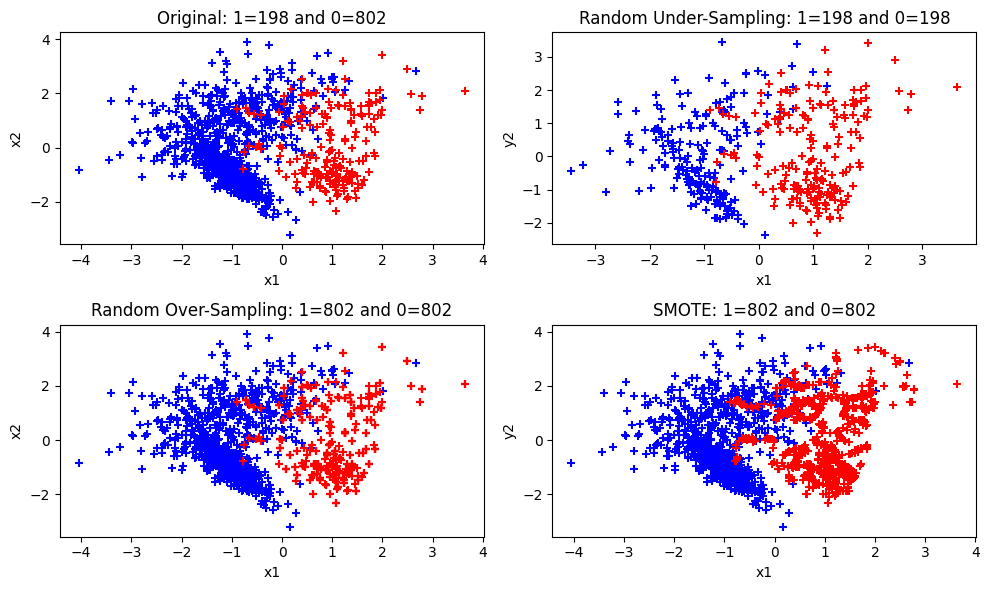

In [10]:
# Original vs resampled subplots
plt.figure(figsize = (10, 6))
plt.subplot(2, 2, 1)
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], marker = '+', color = 'blue')
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], marker='+', color = 'red')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Original: 1=%s and 0=%s' %(Y.tolist().count(1), Y.tolist().count(0)))

plt.subplot(2, 2, 2)
plt.scatter(X_RUS[Y_RUS == 0, 0], X_RUS[Y_RUS == 0, 1], marker = '+', color = 'blue')
plt.scatter(X_RUS[Y_RUS == 1, 0], X_RUS[Y_RUS == 1, 1], marker = '+', color = 'red')
plt.xlabel('x1')
plt.ylabel('y2')
plt.title('Random Under-Sampling: 1=%s and 0=%s' %(Y_RUS.tolist().count(1), Y_RUS.tolist().count(0)))

plt.subplot(2, 2, 3)
plt.scatter(X_ROS[Y_ROS == 0, 0], X_ROS[Y_ROS == 0, 1], marker = '+', color = 'blue')
plt.scatter(X_ROS[Y_ROS == 1, 0], X_ROS[Y_ROS == 1, 1], marker = '+', color = 'red')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Random Over-Sampling: 1=%s and 0=%s' %(Y_ROS.tolist().count(1), Y_ROS.tolist().count(0)))

plt.subplot(2, 2, 4)
plt.scatter(X_SMOTE[Y_SMOTE == 0, 0], X_SMOTE[Y_SMOTE == 0, 1], marker = '+', color = 'blue')
plt.scatter(X_SMOTE[Y_SMOTE == 1, 0], X_SMOTE[Y_SMOTE == 1, 1], marker = '+', color = 'red')
plt.xlabel('x1')
plt.ylabel('y2')
plt.title('SMOTE: 1=%s and 0=%s' %(Y_SMOTE.tolist().count(1), Y_SMOTE.tolist().count(0)))

plt.tight_layout()
plt.show()

**Questions:**
1. What is in your opinion the disadvantage of the Random Under-Sampling technique?
2. What are in your opinion the disadvantages of the Random Over-Sampling and SMOTE techniques?

**Answers:**

## Exercise 7: Comparison of effectiveness of the re-sampling techniques
We'll build classification models for 3 re-sampled data and compare their accuracy using AUC.

In [11]:
from sklearn import tree
from sklearn import metrics

# Split data into train and test
from sklearn.model_selection import train_test_split

X_RUS_train, X_RUS_test, Y_RUS_train, Y_RUS_test = train_test_split(X_RUS, Y_RUS, test_size = 0.3)
X_ROS_train, X_ROS_test, Y_ROS_train, Y_ROS_test = train_test_split(X_ROS, Y_ROS, test_size = 0.3)
X_SMOTE_train, X_SMOTE_test, Y_SMOTE_train, Y_SMOTE_test = train_test_split(X_SMOTE, Y_SMOTE, test_size = 0.3)

# Build a decision tree classifier
clf = tree.DecisionTreeClassifier()
clf_rus = clf.fit(X_RUS_train, Y_RUS_train)
clf_ros = clf.fit(X_ROS_train, Y_ROS_train)
clf_smote = clf.fit(X_SMOTE_train, Y_SMOTE_train)

# Evaluate model performance
print ('RUS - Train AUC:', metrics.roc_auc_score(Y_RUS_train, clf.predict(X_RUS_train)))
print ('RUS - Test AUC:', metrics.roc_auc_score(Y_RUS_test, clf.predict(X_RUS_test)))
print ('\nROS - Train AUC:', metrics.roc_auc_score(Y_ROS_train, clf.predict(X_ROS_train)))
print ('ROS - Test AUC:', metrics.roc_auc_score(Y_ROS_test, clf.predict(X_ROS_test)))
print ('\nSMOTE - Train AUC:', metrics.roc_auc_score(Y_SMOTE_train, clf.predict(X_SMOTE_train)))
print ('SMOTE - Test AUC:', metrics.roc_auc_score(Y_SMOTE_test, clf.predict(X_SMOTE_test)))

RUS - Train AUC: 0.9817773600668339
RUS - Test AUC: 0.976923076923077

ROS - Train AUC: 0.9721864599128354
ROS - Test AUC: 0.9752489773374529

SMOTE - Train AUC: 1.0
SMOTE - Test AUC: 0.9411642699115045


**Questions:**
1. Which re-sampling technique did you find most effective? Justify your answer.
2. What other ways of assessing model quality could you recommend?

**Answers:**

# 3. K-fold cross calidation
**K-fold** cross-validation splits the training dataset into **k** folds without replacement i.e., any given data point will only be part of one of the subset, where **k-1** folds are used for the model training and **one** fold is used for testing. The procedure is repeated **k** times so that we obtain **k** models and performance estimates.

We then calcuate the averge performance of the models based on the individual folds to obtain a performance estimate that is less sensitive to the subpartitioning of the training data compared to the **hold-out** or **single fold** method.

An extended cross-validation is the **stratified k-fold** cross validation, where the class proportions are preserved in each fold leading to a better **bias** and **variance** estimates.

## Exercise 8: Hold-out or single fold model

In [12]:
import pandas as pd
import pylab as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import model_selection

# Read the data
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Lab09/Diabetes.csv')

X = df.iloc[:,:8].values    # Independent variables
y = df['class'].values      # Dependent variable

# Normalize data
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

# Evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Instantiate a logistic regression model, and fit
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)

# Evaluate model
print ('Train score:', clf.score(X_train, y_train))
print ('Test score:', clf.score(X_test, y_test))

Train score: 0.7858472998137802
Test score: 0.7705627705627706


## Exercise 9: 5-fold cross-validation

In [13]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using 5-fold cross-validation
train_scores = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = 5)
test_scores = cross_val_score(clf, X_test, y_test, scoring = 'accuracy', cv = 5)
print ('Train fold AUC scores:', train_scores)
print ('Train CV AUC score:', train_scores.mean())

print ('\nTest fold AUC scores:', test_scores)
print ('Test CV AUC score:', test_scores.mean())

Train fold AUC scores: [0.7962963  0.78703704 0.78504673 0.74766355 0.76635514]
Train CV AUC score: 0.7764797507788163

Test fold AUC scores: [0.70212766 0.7826087  0.7173913  0.82608696 0.76086957]
Test CV AUC score: 0.7578168362627198


**Questions:**
1. Explain, how 5-fold cross-validation is performed?
2. Run the code of exercises 8 and 9 five times and note the results. Compare the results obtained with the single fold model and the 5-fold cross-validation.

**Answers:**

## Exercise 10: Stratified 5-fold cross-validation

In [14]:
kfold = model_selection.StratifiedKFold(n_splits = 5)

train_scores = []
test_scores = []
k = 0
for (train, test) in kfold.split(X_train, y_train):
    clf.fit(X_train[train], y_train[train])
    train_score = clf.score(X_train[train], y_train[train])
    train_scores.append(train_score)
    # Score for test set
    test_score = clf.score(X_train[test], y_train[test])
    test_scores.append(test_score)

    k += 1
    print('Fold: %s, Class distribution: %s, Train Acc: %.3f, Test Acc: %.3f'
          % (k, np.bincount(y_train[train]), train_score, test_score))

print('\nTrain CV accuracy: %.3f' % (np.mean(train_scores)))
print('Test CV accuracy: %.3f' % (np.mean(test_scores)))

Fold: 1, Class distribution: [280 149], Train Acc: 0.783, Test Acc: 0.796
Fold: 2, Class distribution: [280 149], Train Acc: 0.779, Test Acc: 0.787
Fold: 3, Class distribution: [280 150], Train Acc: 0.772, Test Acc: 0.785
Fold: 4, Class distribution: [280 150], Train Acc: 0.786, Test Acc: 0.748
Fold: 5, Class distribution: [280 150], Train Acc: 0.800, Test Acc: 0.766

Train CV accuracy: 0.784
Test CV accuracy: 0.776


**Questions:**
1. Explain, how stratified 5-fold cross-validation is performed?
2. Compare the results obtained with the 5-fold cross-validation and the stratified 5-fold cross-validation.

**Answers:**

## Exercise 11: Plotting the ROC curve for the stratified KFold

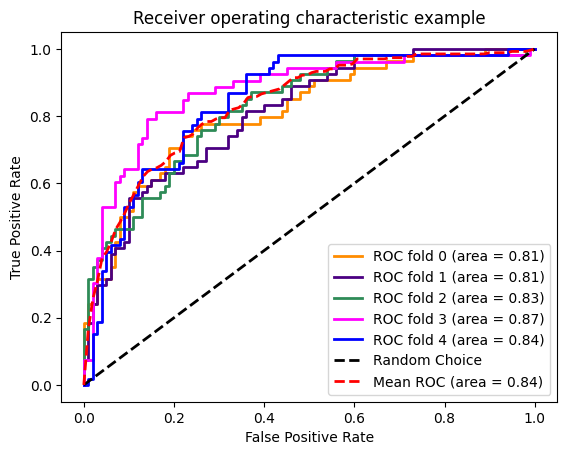

In [15]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from numpy import interp

kfold = model_selection.StratifiedKFold(n_splits=5)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['darkorange', 'indigo', 'seagreen', 'magenta', 'blue'])
lw = 2

i = 0
for (train, test), color in zip(kfold.split(X, y), colors):
    probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
    # Compute the ROC curve and the area under the curve (AUC)
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw = lw, color = color, label = 'ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle = '--', lw = lw, color = 'k', label = 'Random Choice')

mean_tpr /= kfold.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color = 'r', linestyle = '--', label = 'Mean ROC (area = %0.2f)' % mean_auc, lw = lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = 'lower right')
plt.show()

**Questions:**
1. In what situation would you recommend using the AUC index to assess the model quality?
2. Which of the curves shown in the plot corresponds to the best model? Justify your answer?
3. What value of the AUC parameter should be taken as an index of the model quality? Why do you think so?

**Answers:**

# 4. Bagging
**Bootstrap aggregation** (also known as **bagging**) is a model aggregation technique to reduce model variance. The training data is splited into multiple samples with replacement called as **boostrap samples**. Bootstrap sample size is same as original sample size, with **3/4th** of the original values and replacement result in repetition of values.

## Exercise 12: 5-fold cross validation and bagging

In [16]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import metrics

import matplotlib.pyplot as plt

# Bagged decision trees for Classification
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Read the data in
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Lab09/Diabetes.csv')

X = df.iloc[:,:8].values    # Independent variables
y = df['class'].values      # Dependent variable

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Standardization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#kfold = model_selection.StratifiedKFold(n_splits = 5)
#kfold = model_selection.StratifiedKFold(n_splits = 7)
kfold = model_selection.StratifiedKFold(n_splits = 9)
num_trees = 100

# Dection tree with 5-fold cross validation
clf_DT = DecisionTreeClassifier().fit(X_train, y_train)
results = model_selection.cross_val_score(clf_DT, X_train, y_train, cv = kfold)
print ('Decision tree (stand alone) - train:', results.mean())
print ('Decision tree (stand alone) - test:', metrics.accuracy_score(clf_DT.predict(X_test), y_test))

# Using bagging lets build 100 decision tree models and average / majority vote prediction
clf_DT_Bag = BaggingClassifier(estimator = clf_DT, n_estimators = num_trees).fit(X_train, y_train)
results = model_selection.cross_val_score(clf_DT_Bag, X_train, y_train, cv = kfold)
print ('\nDecision tree (bagging) - train:', results.mean())
print ('Decision tree (bagging) - test:', metrics.accuracy_score(clf_DT_Bag.predict(X_test), y_test))

Decision tree (stand alone) - train: 0.7412143601401913
Decision tree (stand alone) - test: 0.6883116883116883

Decision tree (bagging) - train: 0.772118025954343
Decision tree (bagging) - test: 0.7207792207792207


**Questions:**
1. Which method lets us to build a more accurate model? Justify your answer.
2. Could another way of splitting the data improve the results? Check this for 7-fold and 9-fold cross validation.

**Answers:**

## Exercise 13: Feature importances
Decision tree model has an attribute to show important features which is based on the **gini** or **entropy information gain**.

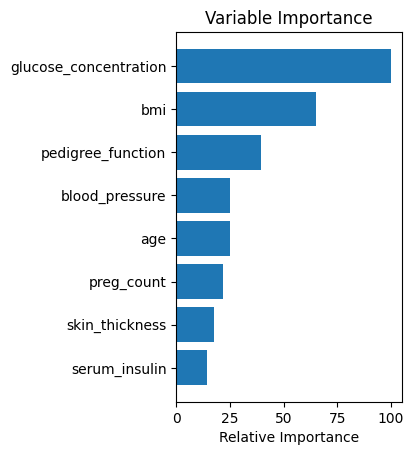

In [17]:
feature_importance = clf_DT.feature_importances_

# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

**Question:**
1. How do you think an information about the feature importances can be used?

**Answer:**

## Exercise 14: Random forest
A **subset of observations** and a **subset of vairables** are randomly picked to build multiple independent **tree** based models. The trees are more un-correlated as only a subset of variables are used during the split of the tree, rather than greedily choosing the best split point in the construction of the tree.

In [54]:
from sklearn.ensemble import RandomForestClassifier
num_trees = 100
# num_trees = 150
# num_trees = 300
# num_trees = 450

X = df.iloc[:,:8].values    # Independent variables
y = df['class'].values      # Dependent variable

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Standardization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

kfold = model_selection.StratifiedKFold(n_splits = 5)



clf_RF = RandomForestClassifier(n_estimators = num_trees).fit(X_train, y_train)
results = model_selection.cross_val_score(clf_RF, X_train, y_train, cv = kfold)

print ('Random forest - train:', results.mean())
print ('Random forest - test:', metrics.accuracy_score(clf_RF.predict(X_test), y_test))

Random forest - train: 0.7606157536985206
Random forest - test: 0.7922077922077922


**Questions:**
1. Is a model built using the **random forest** method better than a model built using the **bagging** method? Justify your answer.
2. Run the **random forest** model building process 5 times and note the accuracy of training and testing each time. How do you justify the different values of the results obtained?
3. How does the number of independent trees used to build a **random forest** model affect its effectiveness? Check this for several values of the **num_trees** parameter.

**Answers:**

## Exercise 15: Extremely randomized trees
This algorithm is an effort to introduce more randomness to the **bagging** process. Tree splits are chosen completely at random from the range of values in the sample at each split which allows to *reduce the variance of the model* further, however at the cost of *slight increase in bias*.

In [41]:
from sklearn.ensemble import ExtraTreesClassifier

num_trees = 100

X = df.iloc[:,:8].values    # Independent variables
y = df['class'].values      # Dependent variable

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Standardization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

kfold = model_selection.StratifiedKFold(n_splits = 5)

clf_ET = ExtraTreesClassifier(n_estimators = num_trees).fit(X_train, y_train)
results = model_selection.cross_val_score(clf_ET, X_train, y_train, cv = kfold)

print ('ExtraTree - train:', results.mean())
print ('ExtraTree - test:', metrics.accuracy_score(clf_ET.predict(X_test), y_test))

ExtraTree - train: 0.75083300013328
ExtraTree - test: 0.7337662337662337


**Questions:**
1. Compare the average accuracy of the **extremely randomized trees** and **random forest** models for **10 trials**. How do you justify your results?
2. Do you think the **test_size** parameter affects the accuracy of model testing? Justify your answer.

**Answers:**